# Goal 1 - What sort of stories become prominent on Medium?

We will perform a multivariate regression of views onto multiple independent variables like word count, reading time, total clap count, and others.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
import string
import re
%matplotlib inline

In [29]:
df = pd.read_csv("Medium_AggregatedData.csv")

In [3]:
df.columns

Index(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount', 'subTitle',
       'tagsCount', 'text', 'title', 'totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'],
      dtype='object')

In [4]:
df.drop(columns=['audioVersionDurationSec', 'codeBlock', 'codeBlockCount', 'collectionId', 'createdDate', 
                 'createdDatetime', 'firstPublishedDate','firstPublishedDatetime','imageCount', 'isSubscriptionLocked',
                 'latestPublishedDate', 'latestPublishedDatetime', 'linksCount', 'responsesCreatedCount', 
                 'socialRecommendsCount','uniqueSlug', 'updatedDate', 'updatedDatetime', 'url', 'vote',
                 'publicationdomain','publicationfacebookPageName', 'publicationdescription',
                 'publicationfollowerCount','publicationname', 'publicationpublicEmail', 'publicationslug',
                 'publicationtags', 'publicationtwitterUsername','slug','name', 'postCount',
                 'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'], inplace=True)

In [5]:
len(df)

279577

In [6]:
df = df[:1000]

In [7]:
df.isnull().any()

language          False
postId            False
readingTime       False
recommends        False
subTitle           True
tagsCount         False
text              False
title             False
totalClapCount    False
wordCount         False
tag_name          False
author            False
bio                True
userId            False
userName          False
dtype: bool

In [8]:
df = df.dropna(axis=0, subset=['subTitle', 'title', 'bio'])

In [9]:
len(df)

777

In [10]:
df['title_len'] = df['title'].str.len()
df['text_len'] = df['text'].str.len()

In [11]:
df['title'] = df['title'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: x.lower())
df['author'] = df['author'].apply(lambda x: x.lower())

In [12]:
df['title_clean'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

In [13]:
df['text_clean'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

In [14]:
df['title_clean'] = df['title'].apply(lambda x: re.sub('[' + string.punctuation + '—]', '', x))
df['text_clean'] = df['text'].apply(lambda x: re.sub('[' + string.punctuation + '—]', '', x))

df['title_clean'] = df['title_clean'].apply(lambda x: x.translate(str.maketrans('', '', string.digits)))
df['text_clean'] = df['text_clean'].apply(lambda x: x.translate(str.maketrans('', '', string.digits)))

df['title_clean'] = df['title_clean'].apply(lambda x: re.sub(' +', ' ', x))
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(' +', ' ', x))

df['title_clean_len'] = df['title_clean'].str.len()
df['text_clean_len'] = df['text_clean'].str.len()

df['full_text'] = df['author'] + ' ' + df['title_clean'] + ' ' + df['text_clean']

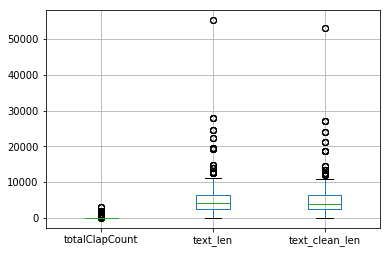

In [15]:
df.boxplot(column=['totalClapCount','text_len','text_clean_len'])
plt.show()

In [19]:
vectorizer = TfidfVectorizer(max_features=None)
full_text_features = vectorizer.fit_transform(df['full_text'])
full_text_features.shape

(777, 17573)

In [20]:
scaler = StandardScaler()
num_features = scaler.fit_transform(df[['readingTime', 
                                        'title_len',
                                        'text_len',
                                        'title_clean_len',
                                        'text_clean_len']])
num_features.shape

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(777, 5)

In [21]:
full_text_features = np.concatenate([full_text_features.toarray(), num_features], axis=1)
full_text_features.shape

(777, 17578)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(full_text_features, df[['totalClapCount']].values, test_size=0.3)
X_train.shape


(543, 17578)

In [23]:
reg = LinearRegression().fit(X_train, y_train)

In [24]:
y_pred = reg.predict(X_test)
y_pred.shape

(234, 1)

In [25]:
r2_score(y_test, y_pred)

0.9991612312089742

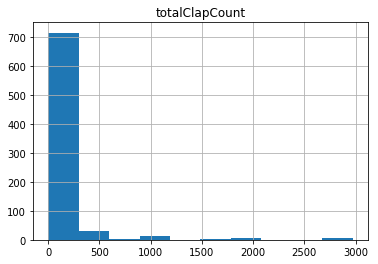

In [26]:
df[['totalClapCount']].hist()
plt.show()

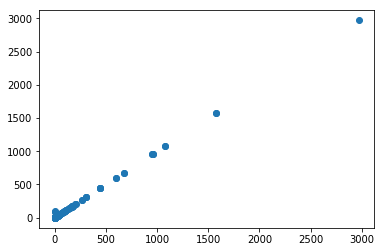

In [27]:
plt.scatter(y_test,y_pred)